# Preliminary info

В данном ноутбуке пример данных из СПб, где здоровый доброволец (ID-27) тестировал нейрореабилитационное ПО от самарской компании IT Universe вместе с чрескожной стимуляцией спинного мозга (ЧССМ). 

Здесь я покажу структуру данных и нарезку на эпохи
Порядок действий в эксперименте в СПб был следующий (см .xlsx файл внутри):
1. Прохождение реабилитационной сессии в VIBRAINT ПО (сначала тренировка алгоритма для различения P300 (папка P300/train) и затем собственно реабилитационная онлайн сессия (папка P300/online))
2. ЧССМ 20 минут
3. Прохождение реабилитационной сессии в VIBRAINT ПО (только реабилитационная онлайн сессия)
4. Упражнения на качание руки ( https://drive.google.com/file/d/13plsJuVXC3G6dvwpQlUBqwO_lLQGHtaP/view?usp=sharing ) без ЧССМ, с ЧССМ в C2, C5, C2 и C5 отделах мозга последовательно, и снова без ЧССМ

Как выглядит тренировочная и реабилитационная онлайн сессии для испытуемого в VR очках:\
https://drive.google.com/file/d/1gxFMEkkTMw7pbuaSPMoeZ1jprGIg-ASx/view 
1. Объявляется целевой (target) шарик, человек проинструктирован смотреть и концентрировать своё внимание на целевом шарике
2. Начинаются рандомные вспышки всех шариков - вспышка целевого шарика вызывает P300 волну, а вспышки остальных (non-target) шариков не вызывают
3. Идёт накопление таргетных и нетаргетных эпох либо до того момента когда алгоритм принятия решений не поймёт на какой шарик смотрел испытуемый, либо до того момента пока не истечёт время на попытку (используется SVMщик с некоторыми ноу-хау) - если алгорим "угадал" таргетный шарик то на экране выбранный шарик загорится, если нет - то все шарики вспыхнут (см видео)
4. Рука с пистолетом едет в реальном тренажёре ( https://vibraint.ai/en/ ) и VR очках к таргетному шарику

Тренировка алгоритма выглядит также как и онлайн сессия, но при тренировке шарики целевыми объявляются последовательно и идёт просто накопление эпох без какого-либо фидбека

Чтобы повторить весь пайплайн - скачайте и распакуйте архив ID-27.zip

## Как выглядят ЭЭГ данные

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
example = pd.read_csv('ID-27/P300/train/2021-10-16-09-42-55/2021-10-16-09-42-55_raw_eeg.csv')
example.head()

# id - индивидуальный номер таймстемпа в ПО

# timestamp - Unix-время в милисекундах когда пришла информация о потенциалах на электродах, для скорости работы инфа с электродов поступает пакетами по 4 - т.е. примерно каждые 16 мс поступает 4 значения потенциала с каждого электрода
# частота дискретизации 250 Гц

# STIMULUS_ID - номер шарика который вспыхнул
# TARGET_ID - номер шарика который был объявлен целевым
# -1 означает что никакой шарик не вспыхивает / никакой шарик не объявлен таргетным
# 0 - крайний левый шарик и 4 крайний правый шарик

,id,timestamp,STIMULUS_ID,TARGET_ID,F7,F3,FZ,F4,F8,T7,...,CZ,C4,T8,A1 (ref),P7,P3,PZ,P4,P8,A2 (ref)
0,174383,1634366575273,-1,-1,6473.779604,2852.002089,708.349643,4454.590055,2971.191547,-1081.738333,...,7476.904652,11127.832560,745.898473,-28175.147823,-7443.457385,2294.970812,-8884.570734,1138.818413,-2355.273549,-25028.712126
1,174384,1634366575273,-1,-1,6541.308904,2912.890763,782.128943,4542.285372,3066.748193,-993.212938,...,7565.478875,11213.965376,833.447305,-28117.530632,-7402.392930,2359.961050,-8802.978934,1226.318418,-2264.746201,-24942.481653
2,174385,1634366575273,-1,-1,6577.392891,2948.047015,824.511758,4589.404515,3105.029444,-942.968795,...,7613.183955,11260.938035,876.123088,-28107.520866,-7380.810897,2394.238395,-8759.521900,1271.679748,-2219.287215,-24909.180871
3,174386,1634366575289,-1,-1,6537.109685,2909.228654,776.855506,4530.615450,3037.939597,-995.507860,...,7552.978874,11201.270063,815.283242,-28156.983759,-7405.371445,2351.464955,-8814.990653,1211.523495,-2279.834093,-24968.018764
4,174387,1634366575289,-1,-1,6476.221011,2851.318495,705.859409,4446.875211,2958.838031,-1079.492239,...,7467.187855,11115.576700,726.269566,-28197.901730,-7444.482775,2289.111437,-8895.215266,1126.074272,-2361.767690,-25034.864470


In [35]:
fs = 250
dt = 1/250

In [36]:
t = np.linspace(0, len(example)*dt, len(example), endpoint=False)

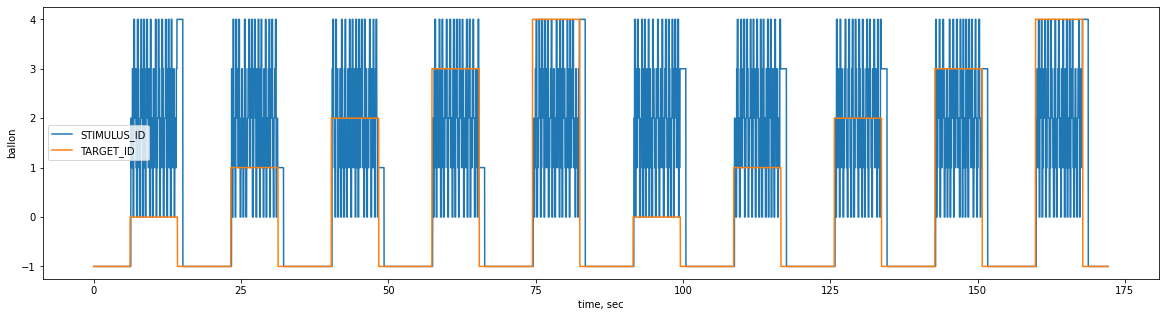

In [37]:
plt.figure(figsize=(20, 5))
plt.plot(t, example.STIMULUS_ID, label='STIMULUS_ID')
plt.plot(t, example.TARGET_ID, label='TARGET_ID')
plt.xlabel('time, sec')
plt.ylabel('ballon')
plt.legend()
plt.show()

# как видно из графика в тренировочной сессии таргетными (TARGET_ID) последовательно объявлялись все шарики
# после объявления в радномном порядке вспыхивали все шарики (STIMULUS_ID)
# так накапливались таргетные и нетаргетные эпохи для тренировки алгоритма для последующего использования натренированного алгоритма в онлайне

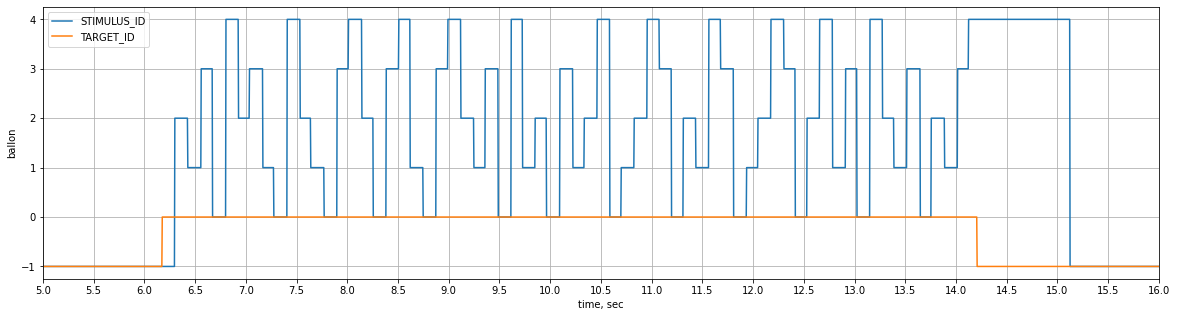

In [38]:
plt.figure(figsize=(20, 5))
plt.plot(t, example.STIMULUS_ID, label='STIMULUS_ID')
plt.plot(t, example.TARGET_ID, label='TARGET_ID')
plt.xlabel('time, sec')
plt.ylabel('ballon')
plt.xlim(5, 16)
plt.xticks(np.linspace(5, 16, 23))
plt.grid()
plt.legend()
plt.show()

# приближение области где один из шариков объявлен таргетным
# вспышка длится 60 мс, пауза после вспышки - 50 мс, но из-за задержек в ПО interstimulus interval получается не 110, а около 120 мс
# т.о. длина одного стимула из STIMULUS_ID порядка около 120 мс на графике

In [39]:
length_of_flash = np.diff(np.where(np.diff(example.STIMULUS_ID) != 0))
length_of_flash = length_of_flash[length_of_flash < 50]
print('средняя длина вспышки', length_of_flash.mean() * dt, 'сек')

средняя длина вспышки 0.12225 сек


Отмечу что частота стимуляции (частота вспышек шариков, 1/~122 ~ 8.18 Гц) очень хорошо выражена на ЭЭГ

## Как выглядят ЭМГ данные

Записывались 4 мышцы - ромбовидная, грудная, надостная и бицепс. Для записи ЭМГ применялась биполярная запись - на каждую мышцу клеилось два электрода (ромбовидная - каналы 25, 26; грудная - каналы 27, 28; надостная - каналы 29, 30; бицепс - каналы 31, 32). Для референса нужно из одного канала на мышце вычесть другой - из 25-ого вычесть 26-ой, из 27-ого вычесть 28-ой и т.д.\

В данных из Самары которые вы будете анализировать ЭМГ будут находиться не в отдельной папке и не в отдельном csv файле, а внутри raw_eeg.csv файла последние 8 электродов будут соответствовать 25, 26, 27, 28, 29, 30, 31, 32 электродам

In [40]:
example_emg = pd.read_csv('ID-27/EMG/online/2021-10-16-11-10-12/2021-10-16-11-10-12_raw_emg.csv')
example_emg.head()

# STIMULUS_ID - это положение руки (см. видео с качанием руки - рука проходит 5 точек, первая точка закодирована нулём, а -1 означает что в данный момент ничего не происходит)
# FES_ID именно в этом эксперименте не нужна, в других экспериментах (где стимуляцию включают/выключают в течение упражнений на нейроинтерфейсе) из этой колонки можно вытащить когда именно стимуляция применялась

,id,timestamp,STIMULUS_ID,FES_ID,25,26,27,28,29,30,31,32
0,1483777,1634371812860,-1,-1,-27504.932947,-25149.415257,-30149.366666,-22175.147538,-29271.632250,-22124.756910,-38248.292832,27974.854844
1,1483778,1634371812860,-1,-1,-27535.499355,-25200.538306,-30181.300262,-22227.442462,-29310.645923,-22252.930744,-38342.433462,24968.995327
2,1483779,1634371812860,-1,-1,-27625.391937,-25287.647685,-30262.061984,-22278.126058,-29386.378349,-22338.135827,-38411.867059,24909.034386
3,1483780,1634371812876,-1,-1,-27660.304048,-25295.460186,-30286.769017,-22263.672932,-29401.466240,-22275.245199,-38369.874869,27892.677106
4,1483781,1634371812876,-1,-1,-27590.968107,-25204.639869,-30216.456513,-22198.487382,-29331.251393,-22142.286208,-38265.138536,29870.997513


# Before start (Поиск нужных папок)

Чтобы проверить что train папка "полная" достаточно проверить есть ли внутри неё папка "Model_Set_1"
<br>Model_Set_1 - папка содержащая параметры обученного классификатора, создаётся после завершения обучения, если она есть в папке - значит обучение прошло успешно и скорее всего использовалось далее. Теоретически параметры классификатора можно поменять, и запустить обучение на тех же данных ещё раз (врачи так не делают как правило) - тогда создатутся папки Model_Set_2 и т.д.

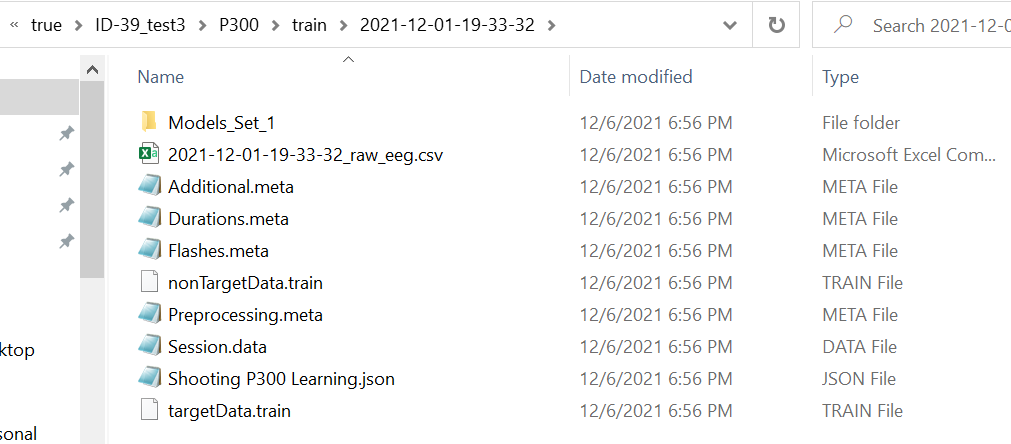

Онлайновые папки я проверяю топорным методом - в этом примере в онлайновой папке должно быть три файла с данными (сырые ЭЭГ, ЭМГ и предобработанное ЭМГ, названия файлов оканчиваются на '_raw_eeg.csv', '_raw_emg.csv' и '_pwr_emg.csv' соответственно) - я проверяю их наличие в папке, а также проверяю наличие всех дополнительных файлов .meta, .data, .json.
<br>Если все файлы в наличии то я проверяю длину файла Session.data - если там было достаточно много попыток сделано, то сохраняю название этой папки и в будущем именно из неё вытягиваю данные.

In [41]:
def check_folders_online(path):
    
    common_files = ['_pwr_emg.csv',
                    '_raw_eeg.csv',
                    '_raw_emg.csv',
                    'Additional.meta',
                    'Flashes.meta',
                    'Preprocessing.meta',
                    'Session.data',
                    'Shooting P300 Rehabilitation.json',
                    'Winners.meta']
    
    complete_folders = []
    
    folders = os.listdir(path)
    
    for folder in folders:
    
        all_files = os.listdir(path+folder)

        ideal = common_files
        ideal[0] = folder+'_pwr_emg.csv'
        ideal[1] = folder+'_raw_eeg.csv'
        ideal[2] = folder+'_raw_emg.csv'

        everything_here = True
        for file in ideal:
            if file not in all_files:
                everything_here = False
                break

        if everything_here:
            session = pd.read_csv(path+folder+'/Session.data')
            if len(session) > 10:
#                print(folder.split('-')[2], folder.split('-')[1], len(session), sum(session.declared == session.predicted) / len(session))
                complete_folders.append(folder)  
                
    return complete_folders

# Imports

In [42]:
!pip install mne
import mne
import matplotlib.pyplot as plt
import scipy
from scipy.signal import iirnotch, sosfiltfilt, filtfilt, butter, detrend, firwin
from scipy.stats import zscore
from scipy import stats
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import os

# Helping functions

In [43]:
# Filtering func 

# Filtering notch 
def filtering_notch(eeg, f_notch, q_factor, fs): 
    # eeg shape (channels, timesteps)
   
    # compute filter coeffs
    b, a = iirnotch(f_notch, q_factor, fs)
    # apply filter
    res = filtfilt(b, a, eeg, padtype='even', padlen=0, axis=-1)

    out_str = 'freq removed ' + str(f_notch) + \
              ' Hz, quality factor ' + str(q_factor) + \
              ', fs ' + str(fs) + ' Hz.'                   
#    print('Filtering_notch: freq removed ' + str(f_notch) + \
#          ' Hz, quality factor ' + str(q_factor) + ', fs ' + str(fs) + ' Hz.')

    return res


# Filtering IIR 
def filtering_iir(eeg, f_type, f1, f2, fs): 
    # eeg shape (channels, timesteps)
    #f_type, string, ex. 'bandpass'
    f_order = 4

    # scale freq to Nyquist
    low = f1 / (fs / 2)
    high = f2 / (fs / 2)

    if f_type == 'bandpass':
        sos = butter(f_order, [low, high], btype='bandpass', output='sos')
    if f_type == 'bandstop':
        sos = butter(f_order, [low, high], btype='bandstop', output='sos')
    if f_type == 'lowpass':
        sos = butter(f_order, low, btype='lowpass', output='sos')
    if f_type == 'highpass':
        sos = butter(f_order, high, btype='highpass', output='sos')

    # apply filter
    res = sosfiltfilt(sos, eeg)

#    print('Filtering_iir: type: ' + f_type + ', freq ' + str(f2) + \
#          ' Hz, order ' + str(f_order) + ', fs ' + str(fs) + ' Hz.')

    return res

In [44]:
# Apply filtering 

# Здесь также добавлены куски про удаление наводки от ЧССМ - игнорируй их, 
# постфактум выяснилось что фильтрами наводка от ЧССМ вообще не удаляется

fs = 250 # Hz
f_notch = 50 # Hz
q_factor = 30
f_type = 'bandpass'
f1 = 1 # Hz
f2 = 15 # Hz

remove_stim_freq = False # удалять или нет частоту стимуляции (1/~122мс)
remove_30_freq = False # удалять или нет частоту ЧССМ
remove_30_60_90_100_freq = False # удалять или нет частоту ЧССМ, её гармоники и гармонику 50 Гц (почему-то она сильнее выражена при ЧССМ)

# 50 Гц для анализа таргетных и нетаргетных эпох я закомментила т.к. low pass frequency 15 Гц

def apply_filter(csv1, fs, f_notch, q_factor, f_type, f1, f2, 
                 remove_stim_freq=remove_stim_freq, 
                 remove_30_freq=remove_30_freq, 
                 remove_30_60_90_100_freq=remove_30_60_90_100_freq):
    fs = fs # Hz
    f_notch = f_notch # Hz
    q_factor = q_factor
    f_type = f_type
    f1 = f1 # Hz
    f2 = f2 # Hz

    # eeg shape must be (channels, timesteps)
    eeg = csv1[:, 4:].T # transpose

    eeg = filtering_notch(eeg, f_notch, q_factor, fs) 
    
    if remove_30_freq:
        q_factor = 2
        f_notch = 30
        eeg = filtering_notch(eeg, f_notch, q_factor, fs) 
    
    if remove_30_60_90_100_freq:
        q_factor = 2
        f_notch = 30
        eeg = filtering_notch(eeg, f_notch, q_factor, fs) 
        
        q_factor = 4
        f_notch = 60
        eeg = filtering_notch(eeg, f_notch, q_factor, fs) 
        
        q_factor = 6
        f_notch = 90
        eeg = filtering_notch(eeg, f_notch, q_factor, fs)

        q_factor = q_factor * 2
        f_notch = 100
        eeg = filtering_notch(eeg, f_notch, q_factor, fs)
    
    if remove_stim_freq:
        eeg = filtering_notch(eeg, 8.18, 3, fs) # stimulation frequency
        
    eeg = filtering_iir(eeg, f_type, f1, f2, fs) 

    # re-construction csv1
    csv1 = np.concatenate((csv1[:, :4], eeg.T), axis=1)
    return csv1

In [45]:
def referenceing_and_filtering(data):

    '''
    Input: pandas dataframe
    Output: (electrodes, numpy array)
    '''

    columns_names = list(data.columns.values)
    electrodes = columns_names[4:]
    
    # Отмечу что референсные электроды могут называться как 'A1', 'A2' так и 'A1 (ref)', 'A2 (ref)'
    # Это зависит от версии ПО

    if ('A1 (ref)' in columns_names) and ('A2 (ref)' in columns_names):
        data['ref'] = (data['A1 (ref)'] + data['A2 (ref)']) / 2
        data = data.drop(['A1 (ref)', 'A2 (ref)'], axis=1)
        electrodes.remove('A1 (ref)')
        electrodes.remove('A2 (ref)')
    elif ('A1' in columns_names) and ('A2' in columns_names):
        data['ref'] = (data['A1'] + data['A2']) / 2
        data = data.drop(['A1', 'A2'], axis=1)
        electrodes.remove('A1')
        electrodes.remove('A2')
    elif ('A1 (ref)' in columns_names) and ('A2 (ref)' not in columns_names):
        data['ref'] = data['A1 (ref)']
        data = data.drop(['A1 (ref)'], axis=1)
        electrodes.remove('A1 (ref)')
    elif ('A1' in columns_names) and ('A2' not in columns_names):
        data['ref'] = data['A1']
        data = data.drop(['A1'], axis=1)
        electrodes.remove('A1')
    else:
        print('Referencing error! No reference channels (neither A1 (ref), A2 (ref) nor A1, A2)')

    if np.shape(data)[0] < 1000:
        return electrodes, []

    data[electrodes] = data[electrodes].sub(data['ref'], axis='rows')
    data = data.drop(['ref'], axis=1)

    data = np.array(data)
    data = apply_filter(data, fs, f_notch, q_factor, f_type, f1, f2, remove_stim_freq, remove_30_freq, remove_30_60_90_100_freq)

    return electrodes, data

In [46]:
def referenceing_and_filtering_emg(data):

    '''
    Input: pandas dataframe
    Output: (electrodes, numpy array)
    '''

    columns_names = list(data.columns.values)
    electrodes = columns_names[4:]

    data['правая ромбовидная 25/26'] = data['25'] - data['26']
    data['правая грудная 27/28'] = data['27'] - data['28']
    data['правая надостная 29/30'] = data['29'] - data['30']
    data['правый бицепс 31/32'] = data['31'] - data['32']

    data = data.drop(['25', '26', '27', '28', '29', '30', '31', '32'], axis=1)

    if np.shape(data)[0] < 1000:
        return electrodes, []

    data = np.array(data)
    data = apply_filter(data, fs, f_notch, q_factor, f_type, 30, 100, )

    return electrodes, data

## Функция для нарезки на эпохи

In [47]:
begin_eeg = 250
end_eeg = 250

def get_epochs(data, begin=begin_eeg, end=end_eeg):
    
# Function cutting into target and non-target epochs
# input - csv files in np.array format
# output - list with two np.arrays - target epochs and non-target epochs

# epochs from -1 to 1 second, baseline correction (mean from -1 to 0) applied 
    
    borders = np.diff(data[:, 3])
    borders = (np.where(borders != 0))[0] + 1 # start (0, 2, 4 etc) and end (1, 3, 5 etc) indices of rounds

    #print(len(borders), borders[0], borders[-1])
    
    starts = np.diff(data[:, 2])
    starts = (np.where(starts != 0))[0] + 1 # starts of epochs (be accurate with ends!!)
    
    target_epochs = np.zeros((len(starts),  begin+end, np.shape(data)[1]))
    non_target_epochs = np.zeros((len(starts),  begin+end, np.shape(data)[1]))
    
    counter_t = 0
    counter_nt = 0
    
    for round_ in range(len(borders) // 2):
        
        interval = starts[starts >= borders[round_*2]]
        interval = interval[interval <= borders[round_*2 + 1] + 1]
        
        for i in interval:
            if np.shape(data[i-begin:i+end])[0] != begin+end:
                pass
            else:
                if data[i, 2] == data[i, 3]:
                    target_epochs[counter_t] = data[i-begin:i+end]
                    counter_t += 1
                elif data[i, 2] != data[i, 3] and data[i, 2] != -1:
                    non_target_epochs[counter_nt] = data[i-begin:i+end]
                    counter_nt += 1
                
    target_epochs = target_epochs[:counter_t]
    non_target_epochs = non_target_epochs[:counter_nt]

    if (np.size(target_epochs) == 0) or (np.size(non_target_epochs) == 0):
        return []
    
    for epochs in [target_epochs, non_target_epochs]:
        
        epochs[:, :, 4:] = epochs[:, :, 4:] - np.mean(epochs[:, round(begin/2):begin, 4:], axis=1)[:, None]
    
    return [target_epochs, non_target_epochs]

# Example of analysis

In [48]:
description = pd.ExcelFile('ID-27/'+'êÉè _ID27.xlsx').parse()
description

,комментарии,регистрируемый показатель (размерность),значение показателя,примечание
0,шифр присваевается после подписания информиров...,ID*,27,NaN
1,дата,(дд.мм.гг),2021-10-16 00:00:00,NaN
2,время,(ч.мин),09:00:00,NaN
3,от 18 до 40 лет,возраст (лет),20,NaN
4,NaN,пол (м/ж),ж,NaN
5,"ЧССМ C2 +C5, 30 Гц , 5 кГц, бифазными импульс...",тип ЧССМ (1/2),1,NaN
6,Пороги моносинаптического ответа мышц при стим...,~ (мА),20,NaN
7,NaN,(file name),ID 27C2,NaN
8,Пороги моносинаптического ответа мышц при стим...,~ (мА),18,NaN
9,NaN,(file name),Id 27C5,NaN


In [49]:
idx = np.array([10, 13, 14, 15, 16, 17, 18])
excersize_names = description['комментарии'].values[idx]
excersize_folders = description['значение показателя'].values[idx]

In [50]:
excersize_names

array(['реабилитационные упражнения на тренажере VIBRAINT RehUp, 20 мин',
       'реабилитационные упражнения на тренажере VIBRAINT RehUp, 20 мин',
       'работа тренажера (качание руки)+ регистрация ЭМГ и ЭЭГ без\xa0ЧССМ (2-3 мин)',
       'работа тренажера (качание руки)+ регистрация ЭМГ и ЭЭГ при ЧССМ (С2), 2-3 мин',
       'работа тренажера (качание руки)+ регистрация ЭМГ и ЭЭГ при ЧССМ (С5), 2-3 мин',
       'работа тренажера (качание руки)+ регистрация ЭМГ и ЭЭГ при ЧССМ (С2+С5), 2-3 мин',
       'работа тренажера (качание руки)+ регистрация ЭМГ и ЭЭГ без\xa0ЧССМ (2-3 мин)'],
      dtype=object)

In [51]:
excersize_folders

array(['2021-10-16-09-54-11', '2021-10-16-10-46-42',
       '2021-10-16-11-10-12', '2021-10-16-11-11-59',
       '2021-10-16-11-13-42', '2021-10-16-11-15-34',
       '2021-10-16-11-17-17'], dtype=object)

In [52]:
train_folder = os.listdir('ID-27/P300/train/')[0]
train_folder

'2021-10-16-09-42-55'

In [53]:
train_data = pd.read_csv('ID-27/P300/train/'+train_folder+'/'+train_folder+'_raw_eeg.csv')
electrodes_used_train, train_data = referenceing_and_filtering(train_data)
train_epochs = get_epochs(train_data)

In [54]:
print('Target epochs (n_epochs, n_timestamps, (id, timestamp, STIMULUS_ID, TARGET_ID)+n_electrodes)', 
      train_epochs[0].shape)
print('Non-target epochs shape (n_epochs, n_timestamps, (id, timestamp, STIMULUS_ID, TARGET_ID)+n_electrodes)',
      train_epochs[1].shape)

Target epochs (n_epochs, n_timestamps, (id, timestamp, STIMULUS_ID, TARGET_ID)+n_electrodes) (130, 500, 19)
Non-target epochs shape (n_epochs, n_timestamps, (id, timestamp, STIMULUS_ID, TARGET_ID)+n_electrodes) (520, 500, 19)


In [55]:
electrodes_used_train, len(electrodes_used_train)

(['F7',
  'F3',
  'FZ',
  'F4',
  'F8',
  'T7',
  'C3',
  'CZ',
  'C4',
  'T8',
  'P7',
  'P3',
  'PZ',
  'P4',
  'P8'],
 15)

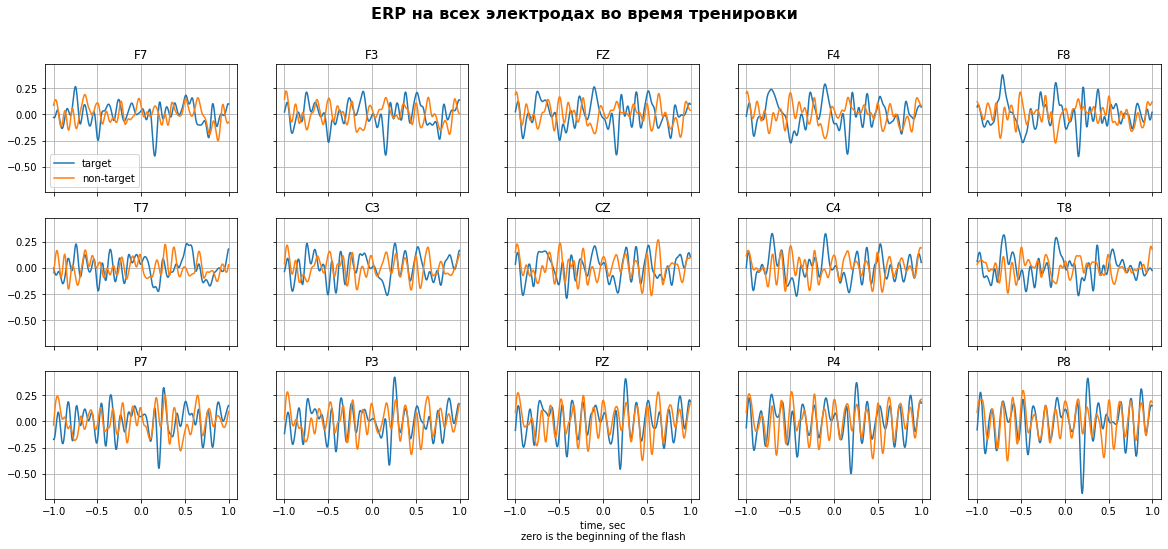

In [56]:
# ERP

figure, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 8), sharex=True, sharey=True)

t = np.linspace(-1, 1, 500, endpoint=False)
row = 0
col = 0

idx = np.random.randint(0, 520, size=130) # выбор 130 рандомных нетаргетных эпох для усреднения чтобы сделать ERP таргета и нонтаргета сравнимыми
# idx = range(520) # потестите и увидите как меняется ERP нетаргета если усреднить все эпохи а не рандомные 130 штук
# эта разница возникает из-за дисбаланса классов в oddball парадигме - эту проблему нужно решать при создании классификатора
# (и именно в этом заключается ноу-хау в классификаторе от VIBRAINT - я подписывала NDA до того как мне самарцы рассказали подробно как именно они это делают :D)

for electrode in range(15):

    axes[row][col].plot(t, np.mean(zscore(train_epochs[0][:, :, electrode+4], axis=-1), axis=0), label='target')
    axes[row][col].plot(t, np.mean(zscore(train_epochs[1][idx, :, electrode+4], axis=-1), axis=0), label='non-target')
    axes[row][col].set_title(electrodes_used_train[electrode])
    axes[row][col].grid()
    col+=1
    if col == 5:
        row+=1
        col=0
        
axes[0][0].legend()
axes[-1][2].set_xlabel('time, sec\nzero is the beginning of the flash')
        
plt.suptitle("ERP на всех электродах во время тренировки", fontsize=16, fontweight='bold')
plt.show()

Можно видеть что лучше всего P300 выражен на P3, Pz, P4 электродах. На самом деле для классификатора используются данные только с этих трёх электродов (остальные записываются для научных целей в надежде что найдутся изменения в ритмах или связности или в чём-то ещё в течение реабилитации). Обычно я смотрю на P300 только на этих электродах и остальные не отрисовываю. Из ERP можно вытянуть амплитуду и латентность P300.

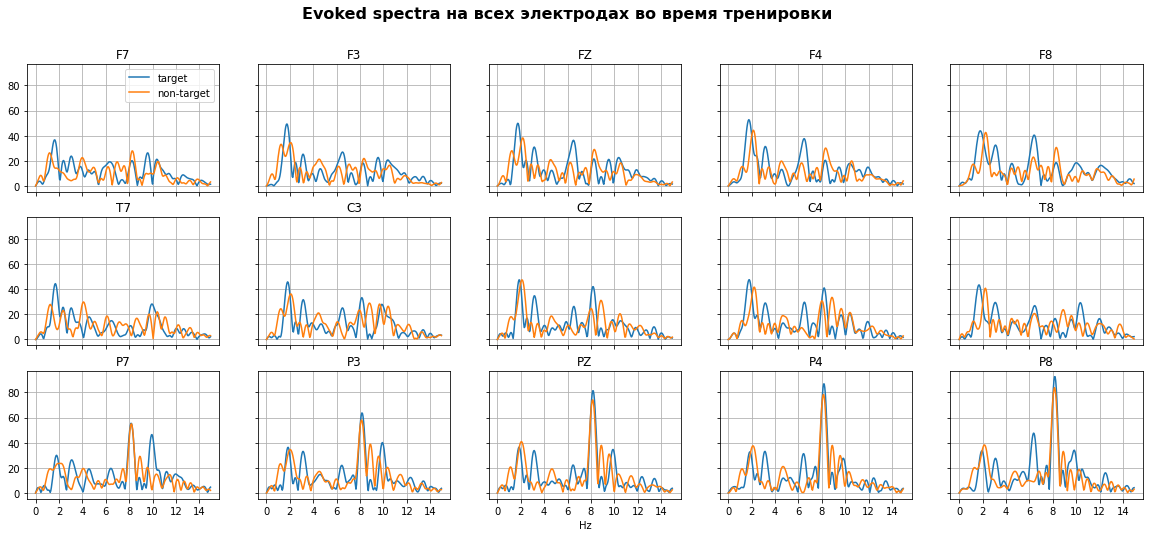

In [57]:
# Evoked spectra

figure, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 8), sharex=True, sharey=True)

t = np.linspace(-1, 1, 500, endpoint=False)
row = 0
col = 0

N = 5000
f = np.arange(N)*(fs/N)
f_max = np.where(f >=15)[0][0]

idx = np.random.randint(0, 520, size=130) # выбор 130 рандомных нетаргетных эпох для усреднения чтобы сделать ERP таргета и нонтаргета сравнимыми
# idx = range(520) 

for electrode in range(15):
    
    evoked_spectra_t = 2 * abs(np.mean(scipy.fft.fft(zscore(train_epochs[0][:, :, electrode+4], axis=-1), n=N)[:, :f_max], axis=0))
    evoked_spectra_nt = 2 * abs(np.mean(scipy.fft.fft(zscore(train_epochs[1][idx, :, electrode+4], axis=-1), n=N)[:, :f_max], axis=0))

    axes[row][col].plot(f[:f_max], evoked_spectra_t, label='target')
    axes[row][col].plot(f[:f_max], evoked_spectra_nt, label='non-target')
    axes[row][col].set_title(electrodes_used_train[electrode])
    axes[row][col].grid()
    axes[row][col].set_xticks(np.arange(0, 16, 2))
    col+=1
    if col == 5:
        row+=1
        col=0
        
axes[0][0].legend()
axes[-1][2].set_xlabel('Hz')
        
plt.suptitle("Evoked spectra на всех электродах во время тренировки", fontsize=16, fontweight='bold')
plt.show()

Пик на evoked спектрах (усреднение результатов FFT в комплексных числах) выделяется только phase-locked activity - высокий пик на париетальных электродах это частота стимуляции (1/122 ~ 8.2 Гц). Все остальные phase-locked выраженные частоты для таргетных эпох это специфическая для P300 активность.

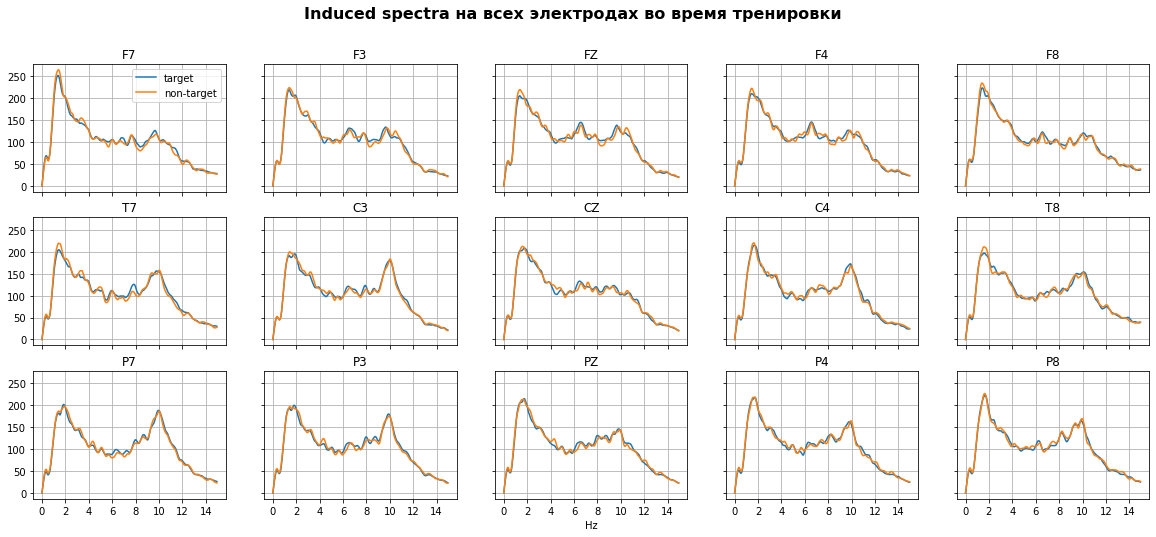

In [58]:
# Induced spectra

figure, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 8), sharex=True, sharey=True)

t = np.linspace(-1, 1, 500, endpoint=False)
row = 0
col = 0

N = 5000
f = np.arange(N)*(fs/N)
f_max = np.where(f >=15)[0][0]

idx = np.random.randint(0, 520, size=130) # выбор 130 рандомных нетаргетных эпох для усреднения чтобы сделать ERP таргета и нонтаргета сравнимыми
# idx = range(520) 

for electrode in range(15):
    
    evoked_spectra_t = 2 * np.mean(abs(scipy.fft.fft(zscore(train_epochs[0][:, :, electrode+4], axis=-1), n=N))[:, :f_max], axis=0)
    evoked_spectra_nt = 2 * np.mean(abs(scipy.fft.fft(zscore(train_epochs[1][idx, :, electrode+4], axis=-1), n=N))[:, :f_max], axis=0)

    axes[row][col].plot(f[:f_max], evoked_spectra_t, label='target')
    axes[row][col].plot(f[:f_max], evoked_spectra_nt, label='non-target')
    axes[row][col].set_title(electrodes_used_train[electrode])
    axes[row][col].grid()
    axes[row][col].set_xticks(np.arange(0, 16, 2))
    col+=1
    if col == 5:
        row+=1
        col=0
        
axes[0][0].legend()
axes[-1][2].set_xlabel('Hz')
        
plt.suptitle("Induced spectra на всех электродах во время тренировки", fontsize=16, fontweight='bold')
plt.show()

А вот на induced спектрах спектры таргетных и нетаргетных эпох не различаются совсем. Можно посчитать спектры до (на протяжении -1 - 0 сек) и после стимула (0 - 1) и из этого вычислить Event-Related Desynchronyzation/Synchronization в разных частотных диапазонах.

In [59]:
freq = np.arange(1, 16, 0.25)
widths = 5*fs / (2*freq*np.pi)

In [60]:
# Wavelets 

t = np.linspace(-1, 1, 500, endpoint=False)
row = 0
col = 0

idx = np.random.randint(0, 520, size=130) # выбор 130 рандомных нетаргетных эпох для усреднения чтобы сделать ERP таргета и нонтаргета сравнимыми
# idx = range(520) # потестите и увидите как меняется ERP нетаргета если усреднить все эпохи а не рандомные 130 штук
# эта разница возникает из-за дисбаланса классов в oddball парадигме - эту проблему нужно решать при создании классификатора
# (и именно в этом заключается ноу-хау в классификаторе от VIBRAINT - я подписывала NDA до того как мне самарцы рассказали подробно как именно они это делают :D)

evoked_wavelets_t = np.zeros((15, len(freq), 500), dtype='complex128')
evoked_wavelets_nt = np.zeros((15, len(freq), 500), dtype='complex128')

induced_wavelets_t = np.zeros((15, len(freq), 500), dtype='float64')
induced_wavelets_nt = np.zeros((15, len(freq), 500), dtype='float64')

for electrode in range(15):
    
    for epoch in range(130): # я пришла к тому что вэйвлеты эпох удобнее делать в таком цикле - иначе мне часто не хватает памяти для хранения вевлетов каждой из эпох
        
        wavelets_t = scipy.signal.cwt(stats.zscore(train_epochs[0][epoch, :, electrode+4]), wavelet=scipy.signal.morlet2, widths=widths, dtype='complex128')
        wavelets_nt = scipy.signal.cwt(stats.zscore(train_epochs[1][idx[epoch], :, electrode+4]), wavelet=scipy.signal.morlet2, widths=widths, dtype='complex128')
        
        evoked_wavelets_t[electrode] += wavelets_t
        evoked_wavelets_nt[electrode] += wavelets_nt
        
        induced_wavelets_t[electrode] += abs(wavelets_t)
        induced_wavelets_nt[electrode] += abs(wavelets_nt)

In [61]:
evoked_wavelets_t /= 130
evoked_wavelets_nt /= 130
induced_wavelets_t /= 130
induced_wavelets_nt /= 130

In [62]:
evoked_wavelets_t = abs(evoked_wavelets_t)
evoked_wavelets_nt = abs(evoked_wavelets_nt)

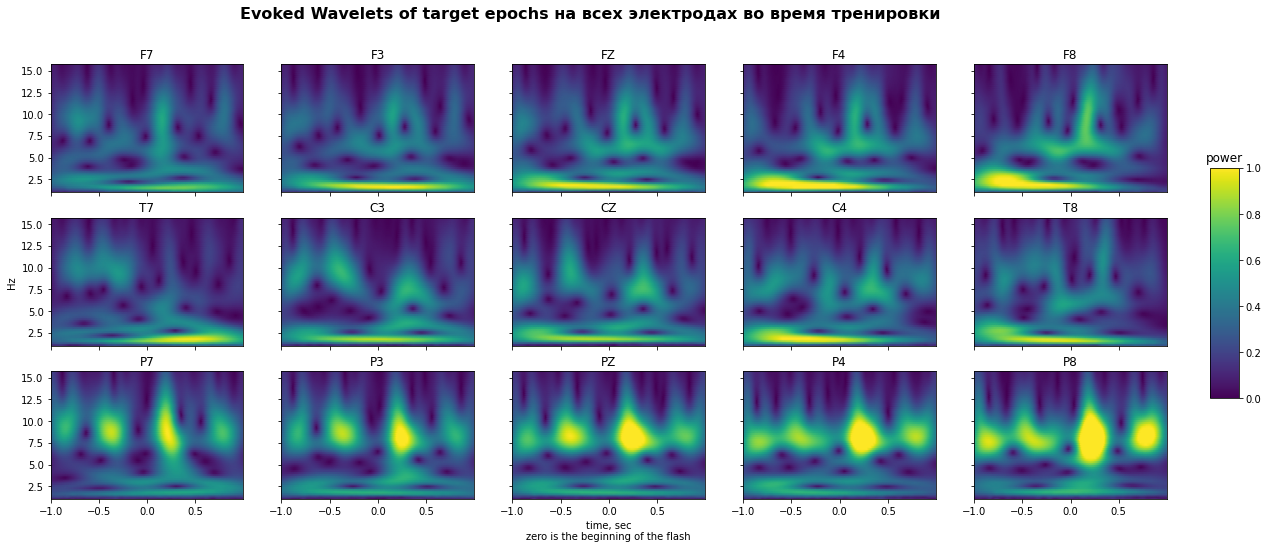

In [63]:
figure, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 8), sharex=True, sharey=True)

col = 0
row = 0

for electrode in range(15):

    cp = axes[row][col].pcolormesh(t, freq, evoked_wavelets_t[electrode], vmin=0, vmax=1, cmap='viridis', shading='gouraud')
    axes[row][col].set_title(electrodes_used_train[electrode])
    col+=1
    if col == 5:
        row+=1
        col=0
        
axes[-1][2].set_xlabel('time, sec\nzero is the beginning of the flash')
axes[1][0].set_ylabel('Hz')

figure.subplots_adjust(right=0.9)
cbar_ax = figure.add_axes([0.93, 0.3, 0.02, 0.4])
cbar = figure.colorbar(cp, cax=cbar_ax)
cbar.ax.set_title('power')
        
plt.suptitle("Evoked Wavelets of target epochs на всех электродах во время тренировки", fontsize=16, fontweight='bold')
plt.show()

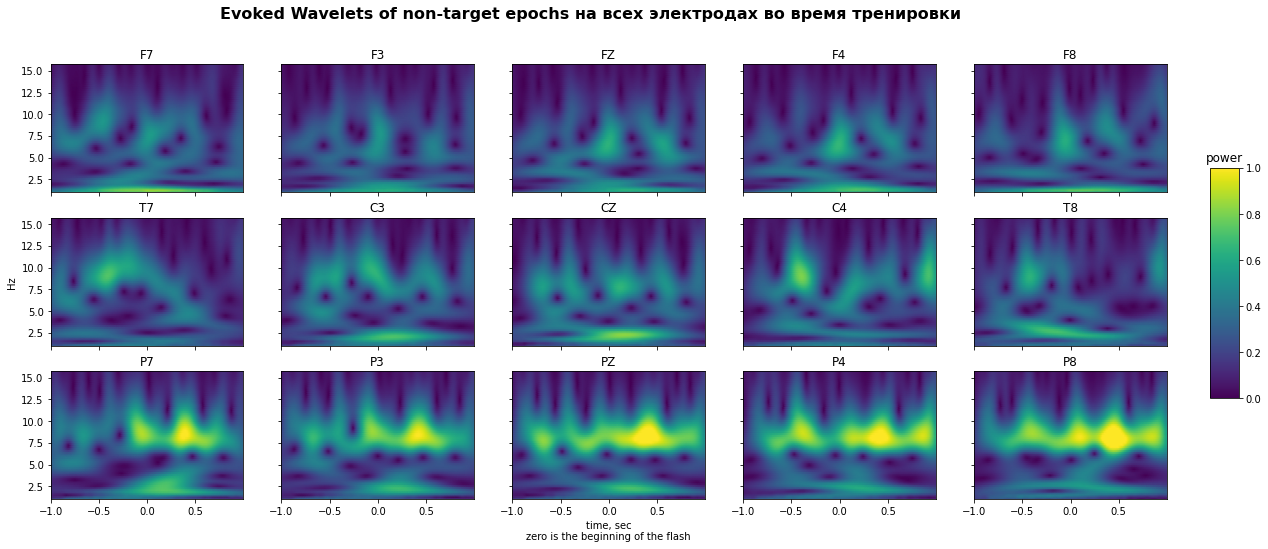

In [64]:
figure, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 8), sharex=True, sharey=True)

col = 0
row = 0

for electrode in range(15):

    cp = axes[row][col].pcolormesh(t, freq, evoked_wavelets_nt[electrode], vmin=0, vmax=1, cmap='viridis', shading='gouraud')
    axes[row][col].set_title(electrodes_used_train[electrode])
    col+=1
    if col == 5:
        row+=1
        col=0
        
axes[-1][2].set_xlabel('time, sec\nzero is the beginning of the flash')
axes[1][0].set_ylabel('Hz')

figure.subplots_adjust(right=0.9)
cbar_ax = figure.add_axes([0.93, 0.3, 0.02, 0.4])
cbar = figure.colorbar(cp, cax=cbar_ax)
cbar.ax.set_title('power')
        
plt.suptitle("Evoked Wavelets of non-target epochs на всех электродах во время тренировки", fontsize=16, fontweight='bold')
plt.show()

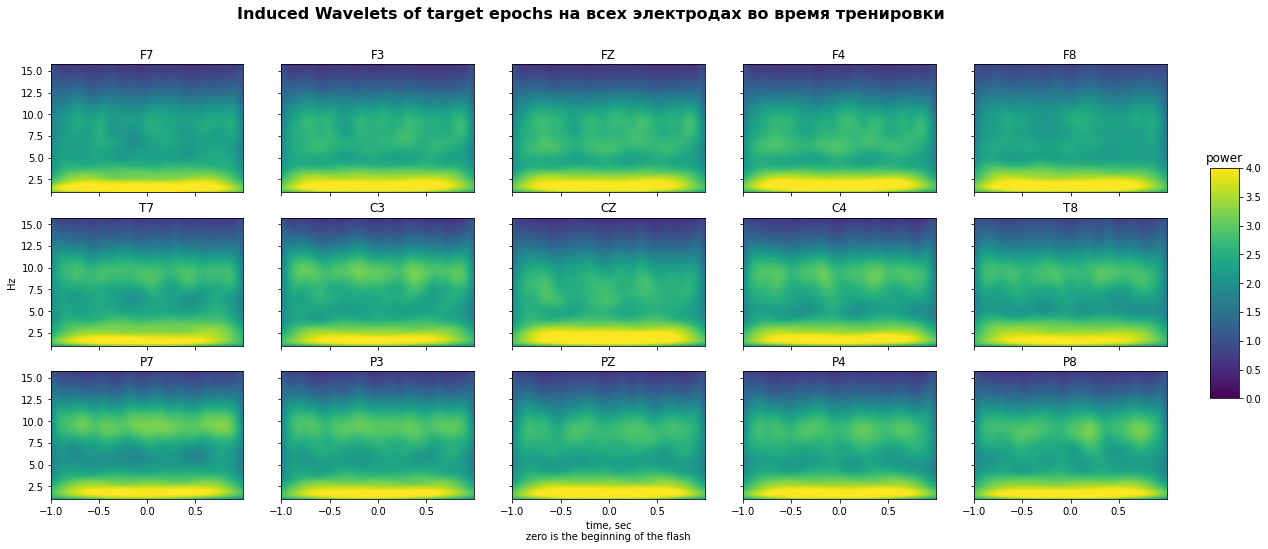

In [65]:
figure, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 8), sharex=True, sharey=True)

col = 0
row = 0

for electrode in range(15):

    cp = axes[row][col].pcolormesh(t, freq, induced_wavelets_t[electrode], vmin=0, vmax=4, cmap='viridis', shading='gouraud')
    axes[row][col].set_title(electrodes_used_train[electrode])
    col+=1
    if col == 5:
        row+=1
        col=0
        
axes[-1][2].set_xlabel('time, sec\nzero is the beginning of the flash')
axes[1][0].set_ylabel('Hz')

figure.subplots_adjust(right=0.9)
cbar_ax = figure.add_axes([0.93, 0.3, 0.02, 0.4])
cbar = figure.colorbar(cp, cax=cbar_ax)
cbar.ax.set_title('power')
        
plt.suptitle("Induced Wavelets of target epochs на всех электродах во время тренировки", fontsize=16, fontweight='bold')
plt.show()

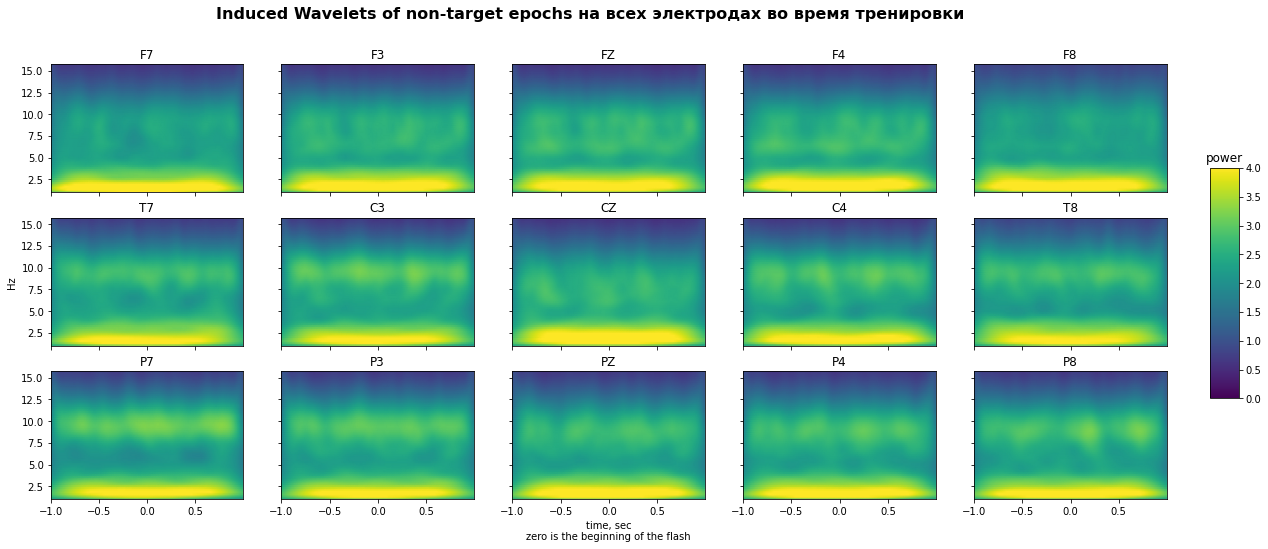

In [66]:
figure, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 8), sharex=True, sharey=True)

col = 0
row = 0

for electrode in range(15):

    cp = axes[row][col].pcolormesh(t, freq, induced_wavelets_t[electrode], vmin=0, vmax=4, cmap='viridis', shading='gouraud')
    axes[row][col].set_title(electrodes_used_train[electrode])
    col+=1
    if col == 5:
        row+=1
        col=0
        
axes[-1][2].set_xlabel('time, sec\nzero is the beginning of the flash')
axes[1][0].set_ylabel('Hz')

figure.subplots_adjust(right=0.9)
cbar_ax = figure.add_axes([0.93, 0.3, 0.02, 0.4])
cbar = figure.colorbar(cp, cax=cbar_ax)
cbar.ax.set_title('power')
        
plt.suptitle("Induced Wavelets of non-target epochs на всех электродах во время тренировки", fontsize=16, fontweight='bold')
plt.show()

Из вейвлетов (и induced, и evoked) можно вытянуть оочень много информации - я видела статьи где использовали вейвлет преобразование ЭЭГ данных, а на получившихся картинках делали fine-tuning свёрточных нейросеток из области Machine Vision предобученных на больших датасетах изображений не имеющих отношения к нейронаукам и получали хорошие результаты по классификации воображаемых движений. А ещё вейвлеты дают очень полное представление о том что происходит в течение эпохи.

Я обычно сначала прописываю прохождение по папкам чтобы выбрать только полные папки (потому что часть из них будет с оборванными записями и т.д.), оборачиваю анализ данных, построение и сохранение графиков в какую нибудь короткую функцию со вложенными for.

In [67]:
# Теперь вы можете повторить то же самое с онлайн данными для этих папок (ID-27/P300/online/...) для тренировки
excersize_folders[:2]

array(['2021-10-16-09-54-11', '2021-10-16-10-46-42'], dtype=object)